## Company Bankruptcy Prediction

## Table of Contents

<ul>
    <li><a href='#intro'>Introduction</a></li>
    <li><a href='#wrangle'>Data Wrangling</a></li>
    <li><a href='#eda'>Exploratory Data Analysis</a></li>
    <li><a href='#conclusion'>Conclusion</a></li>
</ul>

<a id='intro'></a>
## Introduction
The data were collected from the Taiwan Economic Journal for the years 1999 to 2009. 

In this notebook, I built a LightGBM Classifier to predict company bankruptcy using financial features. The model has accuracy 0.99 and F1-score 0.99. Then I used SHAP to explain the predictions of this model. 

I made a [Data Visualization Web Application](https://bankruptcy-visualization.herokuapp.com/) by Streamlit and Heroku. In the application, you can select two random features to generate a scatterplot, with the colors represent bankruptcy condition.

<a id='wrangle'></a>
## Data Wrangling

In [72]:
# Import packages

## general packages
import os
import numpy as np
import pandas as pd

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.transform import factor_cmap, jitter
from bokeh.layouts import row

## Machine learning
import time
from sklearn.model_selection import train_test_split
### Oversampling
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
### LightGBM
import lightgbm as lgb
### Metrics
from sklearn.metrics import roc_auc_score, precision_score, classification_report
### Feature Selection
import shap

In [73]:
# Upload dataset
df = pd.read_csv('data.csv')
df

Bankrupt?   ROA(C) before interest and depreciation before interest  \
0             1                                           0.370594          
1             1                                           0.464291          
2             1                                           0.426071          
3             1                                           0.399844          
4             1                                           0.465022          
...         ...                                                ...          
6814          0                                           0.493687          
6815          0                                           0.475162          
6816          0                                           0.472725          
6817          0                                           0.506264          
6818          0                                           0.493053          

       ROA(A) before interest and % after tax  \
0                                    0.424389   
1                                    0.538214   
2                                    0.499019   
3                                    0.451265   
4                                    0.538432   
...                                       ...   
6814                                 0.539468   
6815                                 0.538269   
6816                                 0.533744   
6817                                 0.559911   
6818                                 0.570105   

       ROA(B) before interest and depreciation after tax  \
0                                              0.405750    
1                                              0.516730    
2                                              0.472295    
3                                              0.457733    
4                                              0.522298    
...                                                 ...    
6814                                           0.543230    
6815                                           0.524172    
6816                                           0.520638    
6817                                           0.554045    
6818                                           0.549548    

       Operating Gross Margin   Realized Sales Gross Margin  \
0                    0.601457                      0.601457   
1                    0.610235                      0.610235   
2                    0.601450                      0.601364   
3                    0.583541                      0.583541   
4                    0.598783                      0.598783   
...                       ...                           ...   
6814                 0.604455                      0.604462   
6815                 0.598308                      0.598308   
6816                 0.610444                      0.610213   
6817                 0.607850                      0.607850   
6818                 0.627409                      0.627409   

       Operating Profit Rate   Pre-tax net Interest Rate  \
0                   0.998969                    0.796887   
1                   0.998946                    0.797380   
2                   0.998857                    0.796403   
3                   0.998700                    0.796967   
4                   0.998973                    0.797366   
...                      ...                         ...   
6814                0.998992                    0.797409   
6815                0.998992                    0.797414   
6816                0.998984                    0.797401   
6817                0.999074                    0.797500   
6818                0.998080                    0.801987   

       After-tax net Interest Rate  \
0                         0.808809   
1                         0.809301   
2                         0.808388   
3                         0.808966   
4                         0.809304   
...                            ...   
6814                      0

In [74]:
df2=df.copy()
df2['Bankrupt?'].replace({0:'No', 1: 'Yes'}, inplace=True)
df2

Bankrupt?   ROA(C) before interest and depreciation before interest  \
0          Yes                                           0.370594          
1          Yes                                           0.464291          
2          Yes                                           0.426071          
3          Yes                                           0.399844          
4          Yes                                           0.465022          
...        ...                                                ...          
6814        No                                           0.493687          
6815        No                                           0.475162          
6816        No                                           0.472725          
6817        No                                           0.506264          
6818        No                                           0.493053          

       ROA(A) before interest and % after tax  \
0                                    0.424389   
1                                    0.538214   
2                                    0.499019   
3                                    0.451265   
4                                    0.538432   
...                                       ...   
6814                                 0.539468   
6815                                 0.538269   
6816                                 0.533744   
6817                                 0.559911   
6818                                 0.570105   

       ROA(B) before interest and depreciation after tax  \
0                                              0.405750    
1                                              0.516730    
2                                              0.472295    
3                                              0.457733    
4                                              0.522298    
...                                                 ...    
6814                                           0.543230    
6815                                           0.524172    
6816                                           0.520638    
6817                                           0.554045    
6818                                           0.549548    

       Operating Gross Margin   Realized Sales Gross Margin  \
0                    0.601457                      0.601457   
1                    0.610235                      0.610235   
2                    0.601450                      0.601364   
3                    0.583541                      0.583541   
4                    0.598783                      0.598783   
...                       ...                           ...   
6814                 0.604455                      0.604462   
6815                 0.598308                      0.598308   
6816                 0.610444                      0.610213   
6817                 0.607850                      0.607850   
6818                 0.627409                      0.627409   

       Operating Profit Rate   Pre-tax net Interest Rate  \
0                   0.998969                    0.796887   
1                   0.998946                    0.797380   
2                   0.998857                    0.796403   
3                   0.998700                    0.796967   
4                   0.998973                    0.797366   
...                      ...                         ...   
6814                0.998992                    0.797409   
6815                0.998992                    0.797414   
6816                0.998984                    0.797401   
6817                0.999074                    0.797500   
6818                0.998080                    0.801987   

       After-tax net Interest Rate  \
0                         0.808809   
1                         0.809301   
2                         0.808388   
3                         0.808966   
4                         0.809304   
...                            ...   
6814                      0.809331   


In [75]:
df.describe()

Bankrupt?   ROA(C) before interest and depreciation before interest  \
count  6819.000000                                        6819.000000          
mean      0.032263                                           0.505180          
std       0.176710                                           0.060686          
min       0.000000                                           0.000000          
25%       0.000000                                           0.476527          
50%       0.000000                                           0.502706          
75%       0.000000                                           0.535563          
max       1.000000                                           1.000000          

        ROA(A) before interest and % after tax  \
count                              6819.000000   
mean                                  0.558625   
std                                   0.065620   
min                                   0.000000   
25%                                   0.535543   
50%                                   0.559802   
75%                                   0.589157   
max                                   1.000000   

        ROA(B) before interest and depreciation after tax  \
count                                        6819.000000    
mean                                            0.553589    
std                                             0.061595    
min                                             0.000000    
25%                                             0.527277    
50%                                             0.552278    
75%                                             0.584105    
max                                             1.000000    

        Operating Gross Margin   Realized Sales Gross Margin  \
count              6819.000000                   6819.000000   
mean                  0.607948                      0.607929   
std                   0.016934                      0.016916   
min                   0.000000                      0.000000   
25%                   0.600445                      0.600434   
50%                   0.605997                      0.605976   
75%                   0.613914                      0.613842   
max                   1.000000                      1.000000   

        Operating Profit Rate   Pre-tax net Interest Rate  \
count             6819.000000                 6819.000000   
mean                 0.998755                    0.797190   
std                  0.013010                    0.012869   
min                  0.000000                    0.000000   
25%                  0.998969                    0.797386   
50%                  0.999022                    0.797464   
75%                  0.999095                    0.797579   
max                  1.000000                    1.000000   

        After-tax net Interest Rate  \
count                   6819.000000   
mean                       0.809084   
std                        0.013601   
min                        0.000000   
25%                        0.809312   
50%                        0.809375   
75%                        0.809469   
max                        1.000000   

        Non-industry income and expenditure/revenue  ...  \
count                                   6819.000000  ...   
mean                                       0.303623  ...   
std                                        0.011163  ...   
min                                        0.000000  ...   
25%                                        0.303466  ...   
50%                                        0.303525  ...   
75%                                        0.303585  ...   
max                                        1.000000  ...   

        Net Income to Total Assets   Total assets to GNP price  \
count                  6819.000000                6.819000e+03   
mean                      0.807760                1.862942e+07   
std                       0.040332                3.764501e+08   
min

Normalize each feature

There are 95 variables describing the condition of companies, plus one column "Bankrupt?" as the label.

The number of records is 6819.

Next, I'll check the existence of replicates and null values.

In [76]:
# check duplicates
df.duplicated().sum()

0

In [77]:
# check null values
df.isnull().any().any()

False

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

### Class Balancing

In [79]:
labels = df['Bankrupt?'].value_counts()
labels.index=['No', 'Yes']
labels

No     6599
Yes     220
Name: Bankrupt?, dtype: int64

To solve the unbalance of labels, I'll use SMOTEENN method to oversample the minority class then clean the noisy samples.

In [80]:
ori_X = df.drop(['Bankrupt?'], axis=1)
ori_y = df['Bankrupt?']

smote_enn = SMOTEENN(random_state=28)
X, y = smote_enn.fit_resample(ori_X, ori_y)

In [81]:
new_labels = y.value_counts()
new_labels.index = ['No', 'Yes']
new_labels

No     6256
Yes    5426
Name: Bankrupt?, dtype: int64

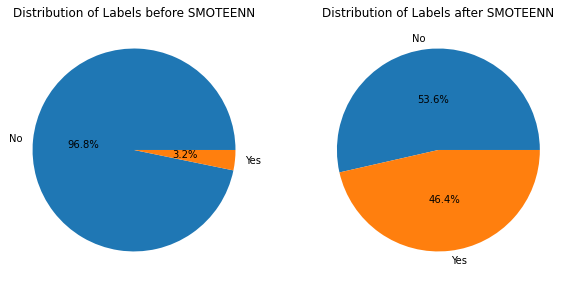

In [82]:
fig = plt.figure(figsize=[10, 6])
gs = fig.add_gridspec(1, 2)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

ax0.pie(labels, labels=labels.index, pctdistance=0.5, autopct='%.1f%%')
ax1.pie(new_labels, labels=new_labels.index, pctdistance=0.5, autopct='%.1f%%')

ax0.set_title('Distribution of Labels before SMOTEENN')
ax1.set_title('Distribution of Labels after SMOTEENN');

<a id='eda'></a>
## Exploratory Data Analysis

### Modeling

Use Scikit-learn API:

In [58]:
# Split data into random train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=28)
# Set the dataset
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)
# Specify parameters
params = {'boosting':'gbdt',
          'max_bin':512,
          'num_leaves':10,
          'learning_rate':0.03,
          'objective':'binary',
          'force_col_wise':True,
          'metric':'binary_logloss'}

# Train
lgbm = lgb.train(params, d_train, 1000)

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4990, number of negative: 4355
[LightGBM] [Info] Total Bins 47616
[LightGBM] [Info] Number of data points in the train set: 9345, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.533975 -> initscore=0.136111
[LightGBM] [Info] Start training from score 0.136111


In [59]:
y_pred = lgbm.predict(X_test)
y_pred = y_pred.round(0)
y_pred = y_pred.astype(int)

In [60]:
roc_auc_score(y_pred, y_test)

0.9880002546050957

In [61]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1071
           1       0.98      1.00      0.99      1266

    accuracy                           0.99      2337
   macro avg       0.99      0.99      0.99      2337
weighted avg       0.99      0.99      0.99      2337



### Feature selection

In [62]:
# Load JS visualization code
shap.initjs()

# Explain the model's predictions using SHAP
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [24]:
shap_values[1].shape

(11682, 95)

#### The total impact of features on the model

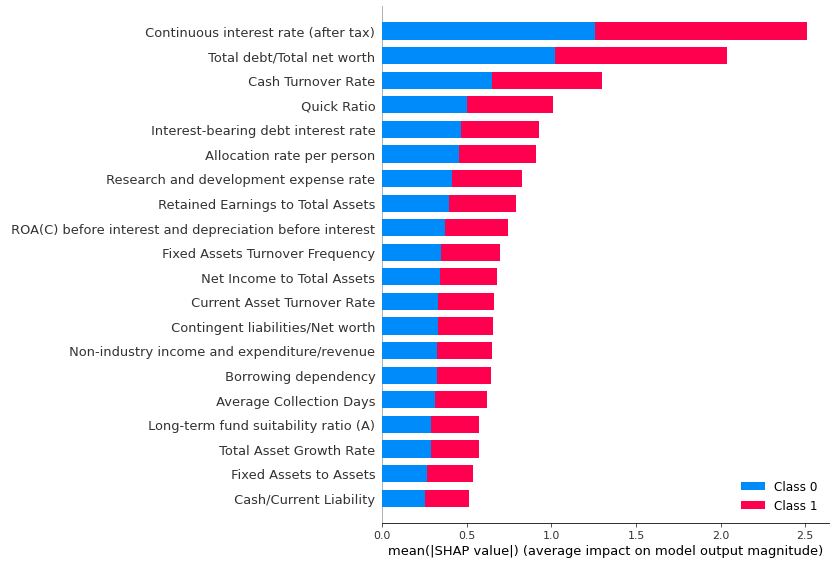

In [25]:
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns, plot_type='bar')

This plot shows the importance of features in a descending order. For example, the top feature "Continuous interest rate" contribute more to the model than the second feature "Total debt/total net worth". To figure out the relationships between features and labels,I plotted the effect of these features on all records in the training data as shown below:

#### The impact of features on the model for individual data

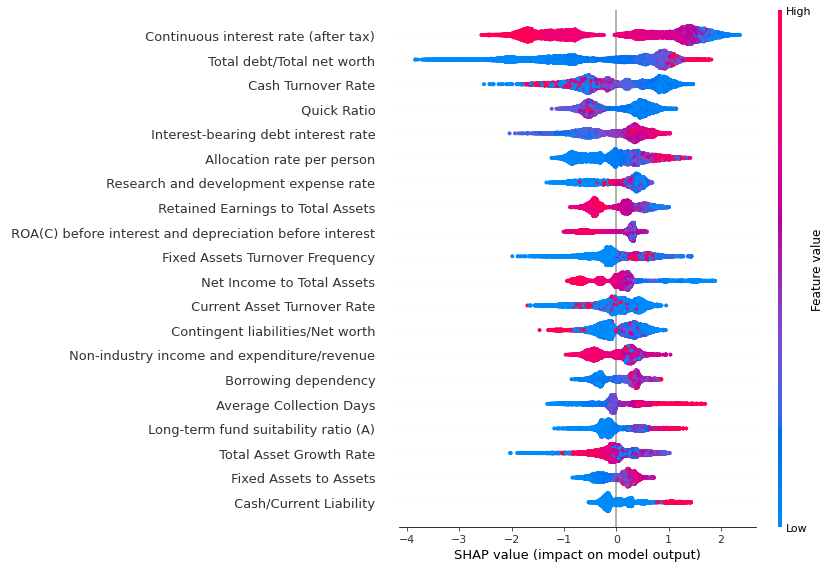

In [27]:
shap.summary_plot(shap_values[1], features=X, feature_names=X.columns)

This plot shows the positive and negative relationships of the features with the label. Similarly, features are ranked in descending order. Each dot represents one record in the training data. The color represents the value of the feature (red high, blue low). The horizontal axis represents the effect of feature on model prediction. For example, high continuous interest rate lowers the probability that model predict bankrupt. There is a negative relationship between continuous interest rate with bankrupt.

#### The effect of a single feature across the whole dataset

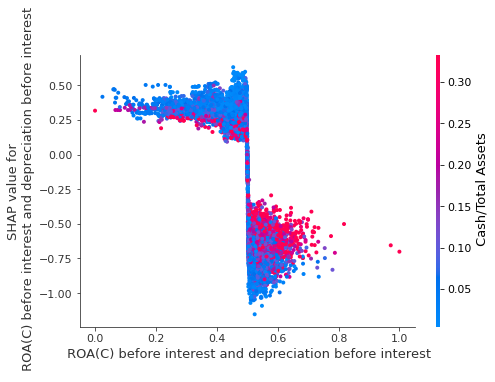

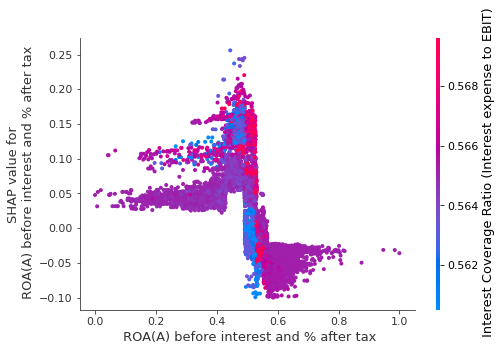

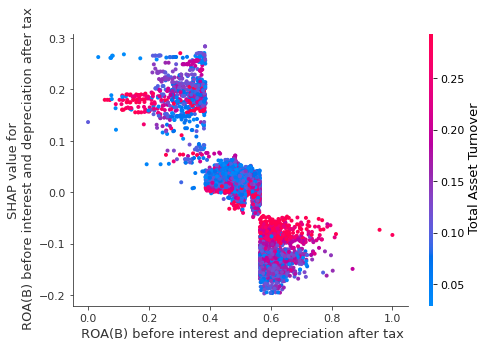

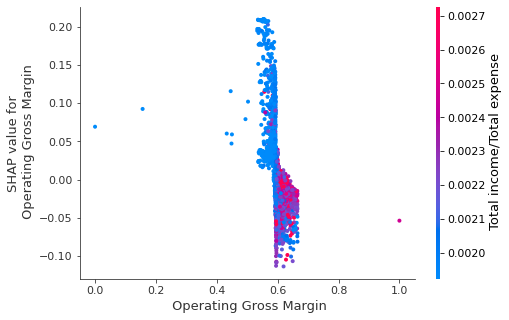

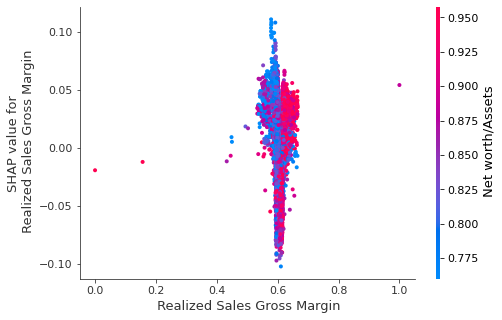

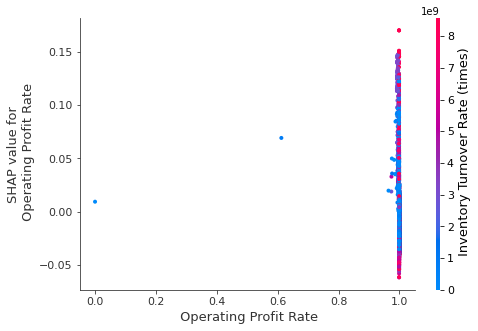

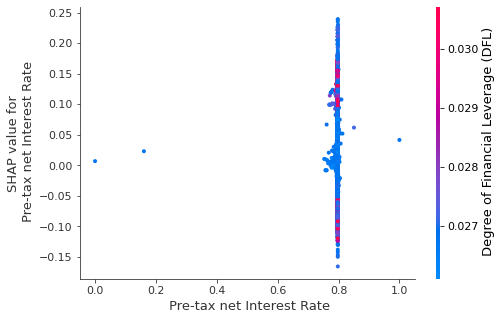

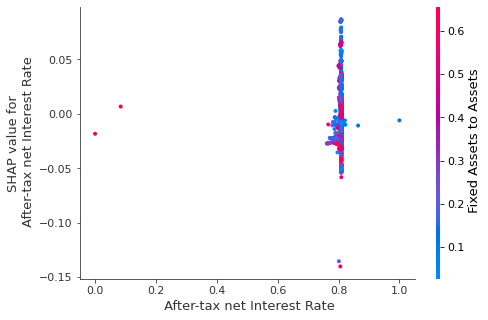

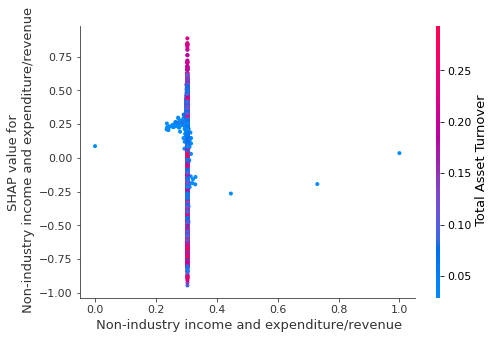

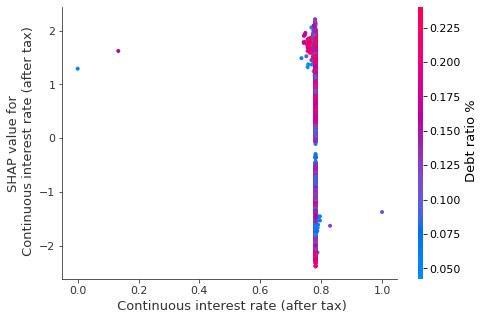

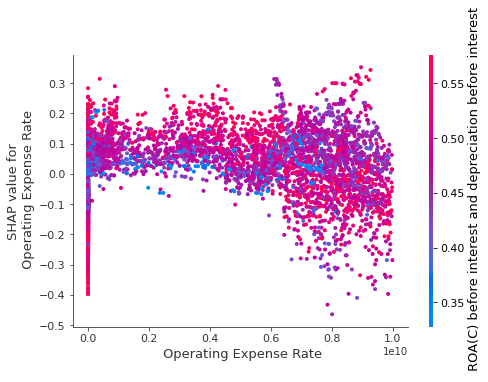

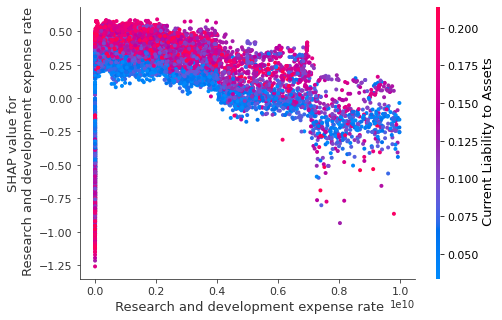

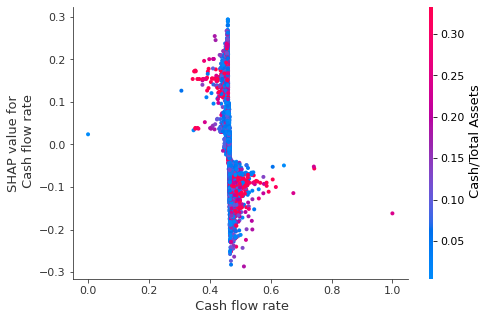

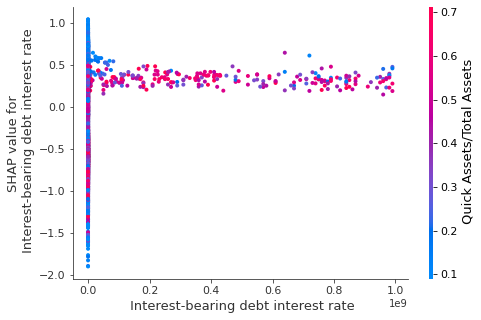

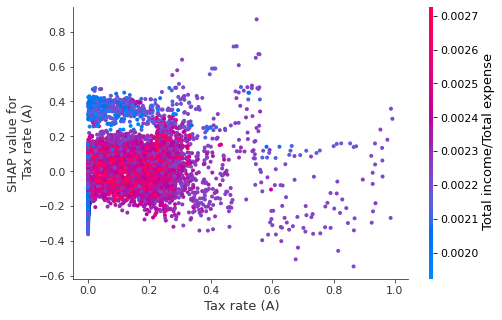

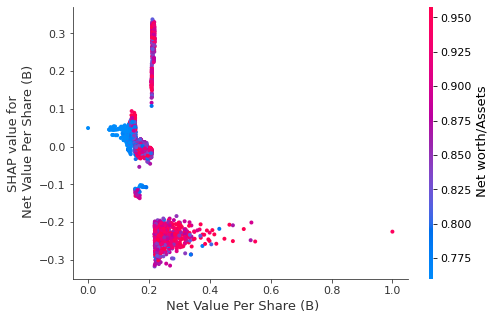

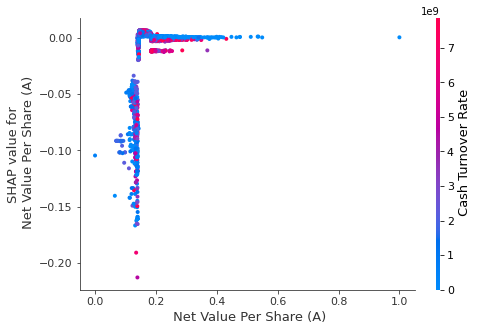

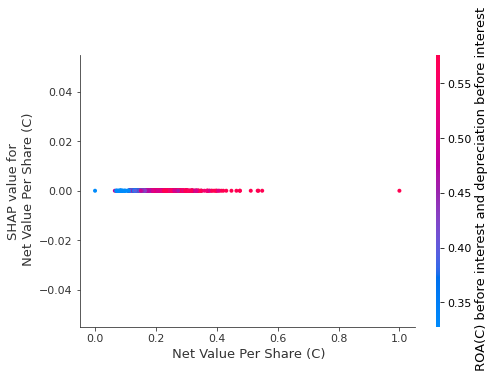

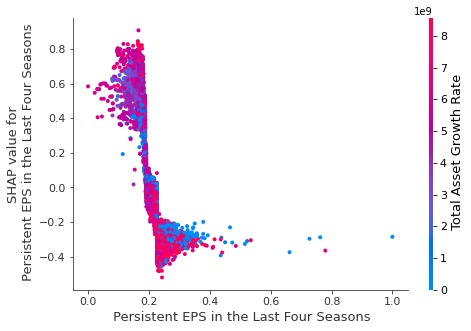

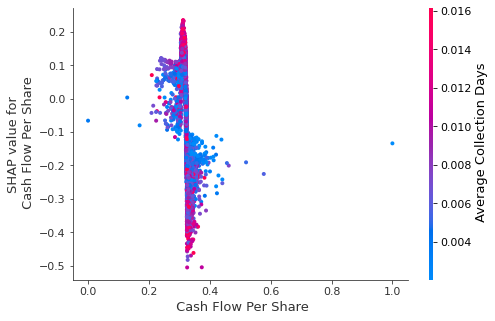

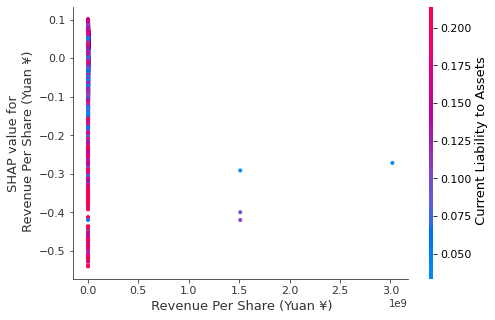

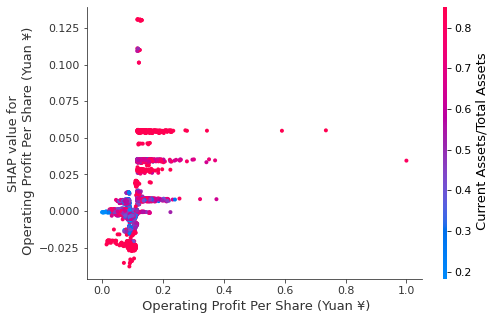

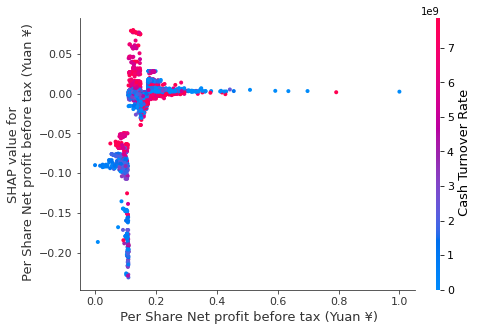

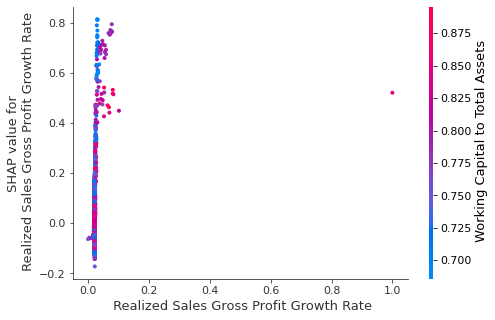

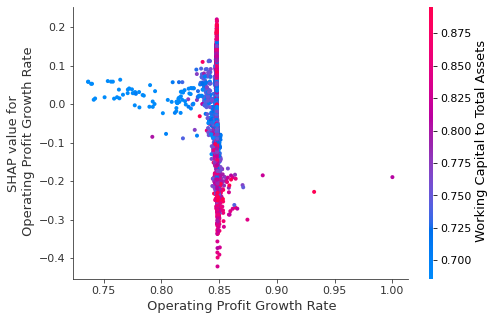

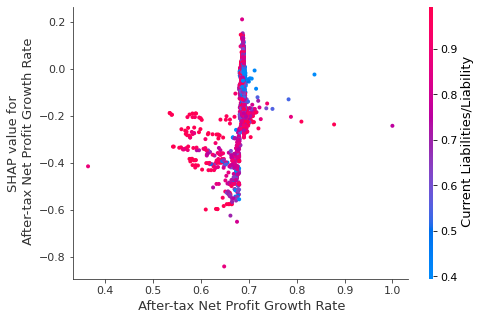

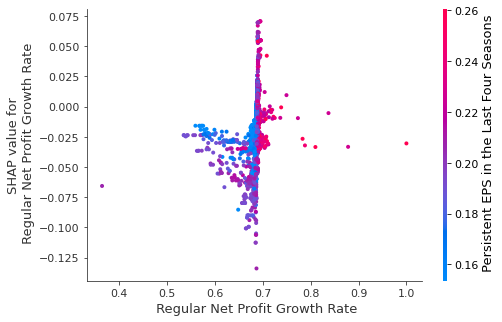

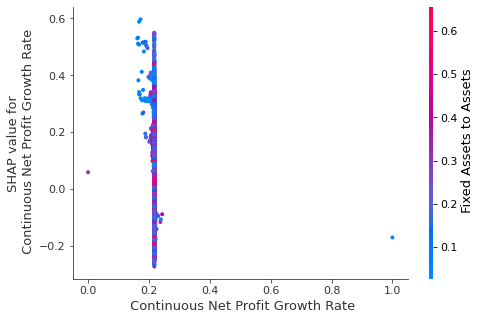

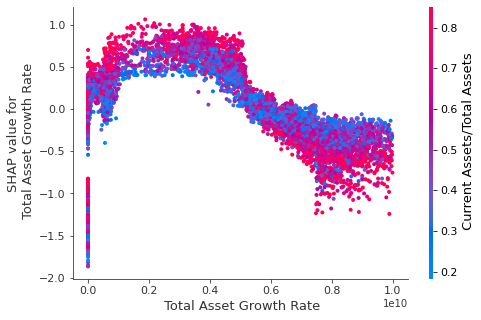

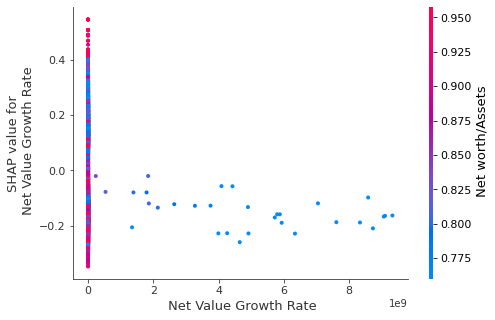

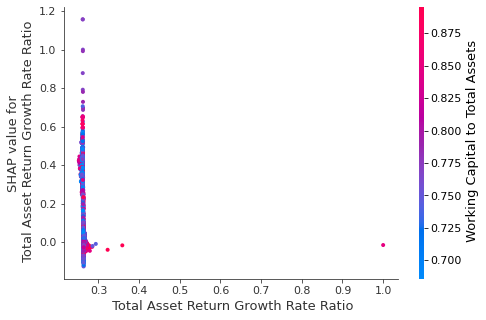

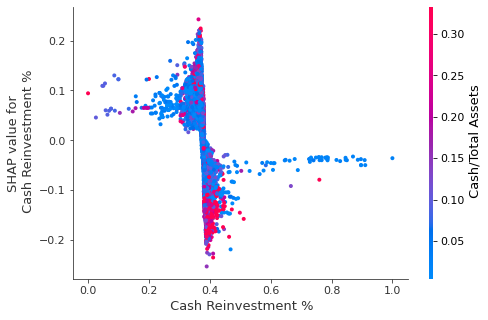

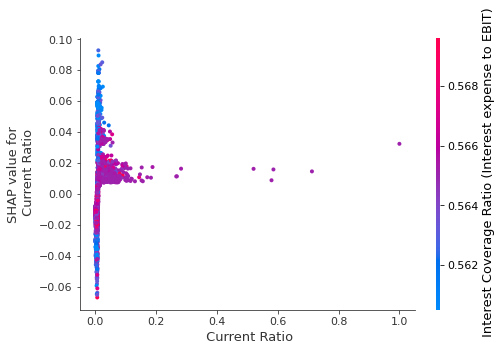

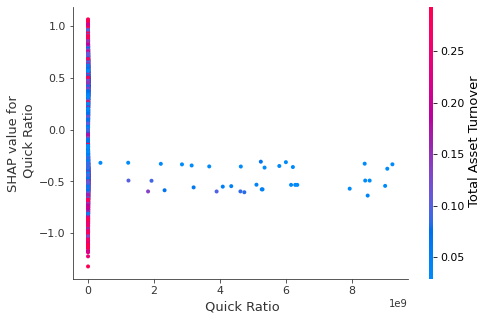

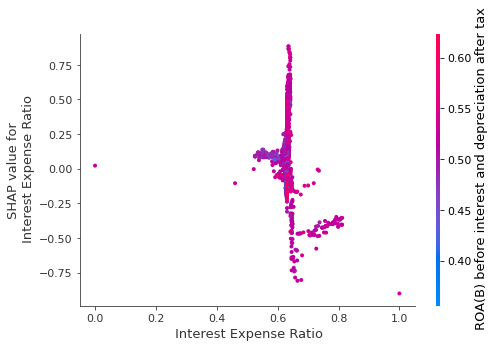

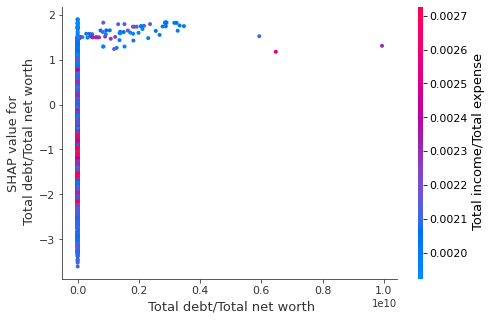

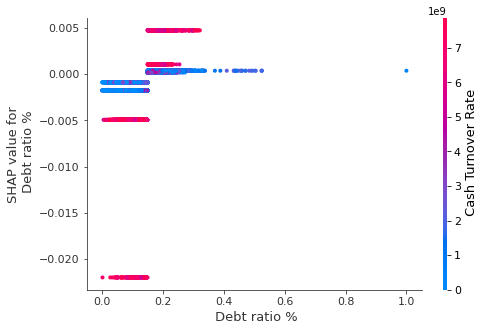

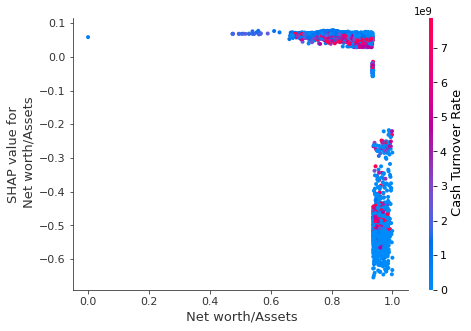

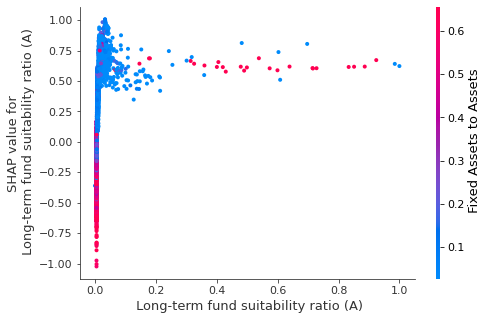

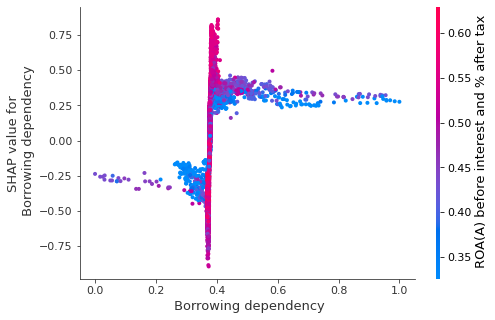

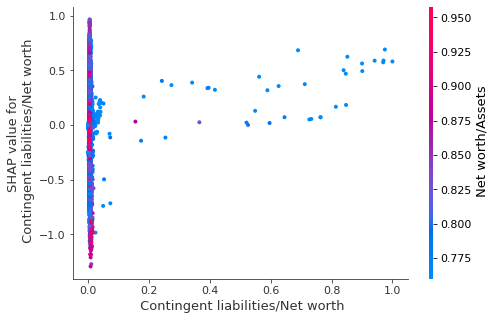

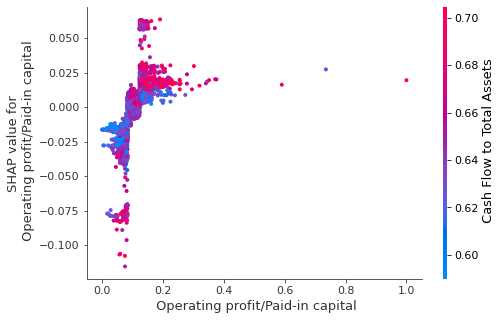

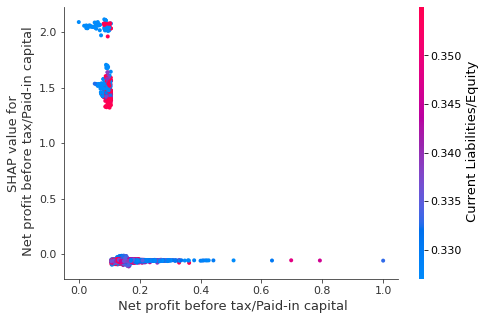

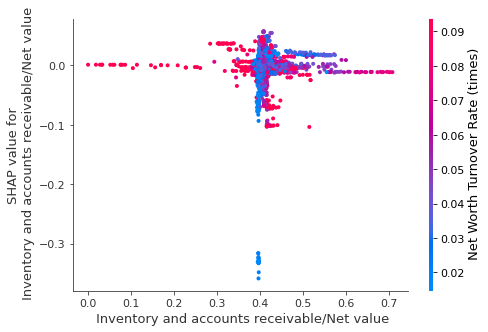

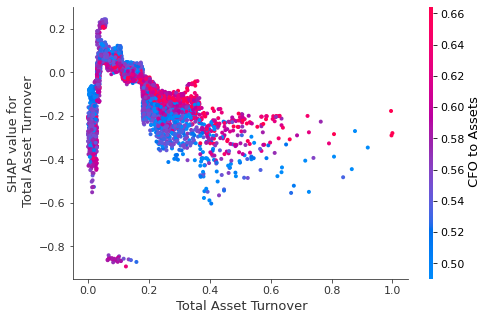

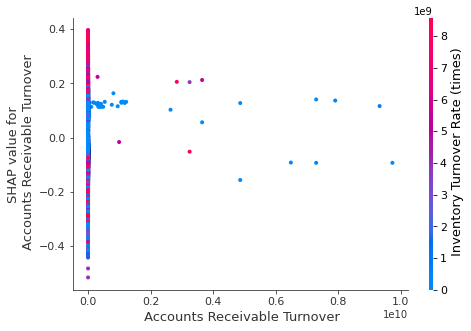

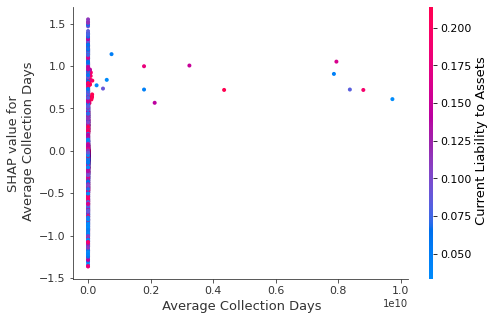

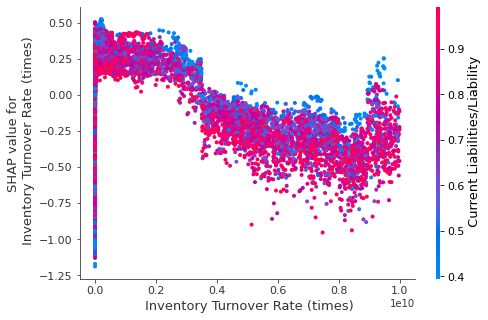

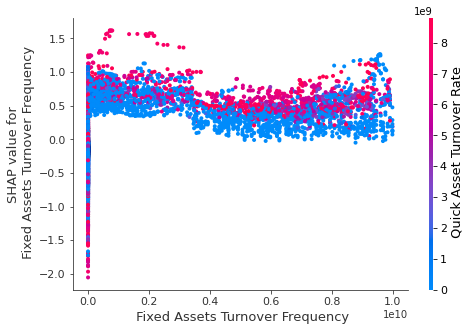

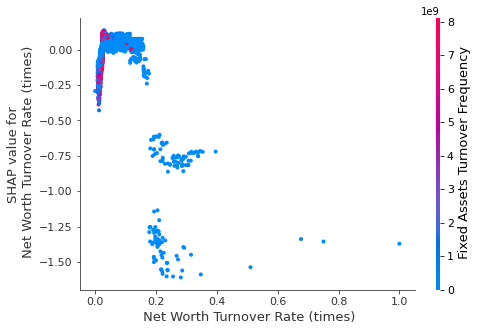

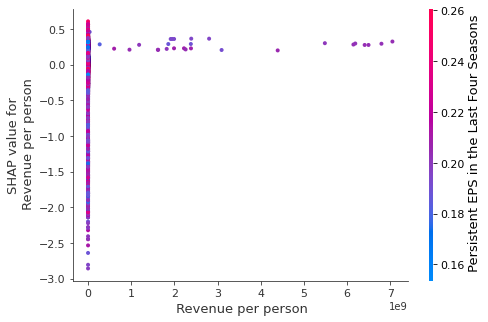

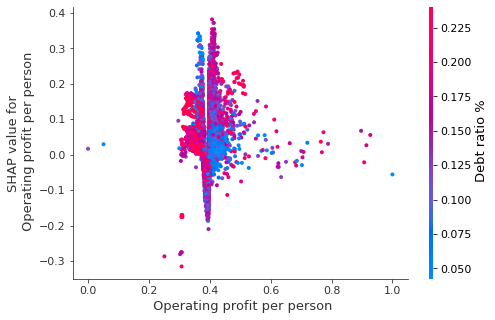

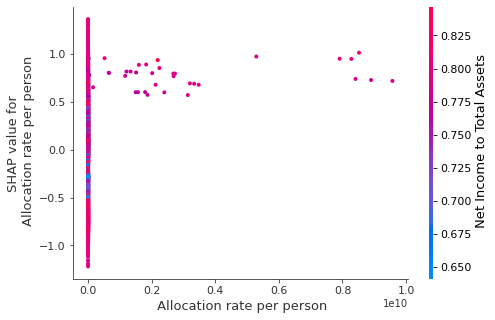

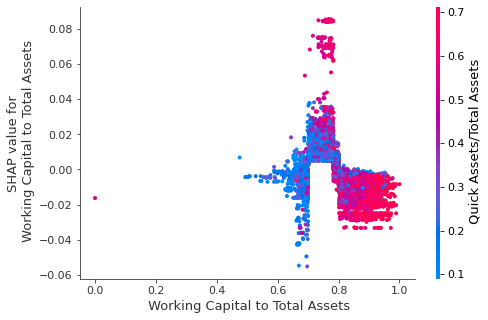

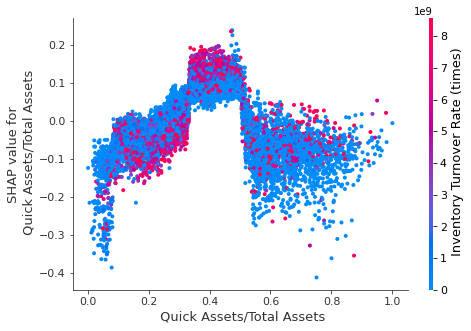

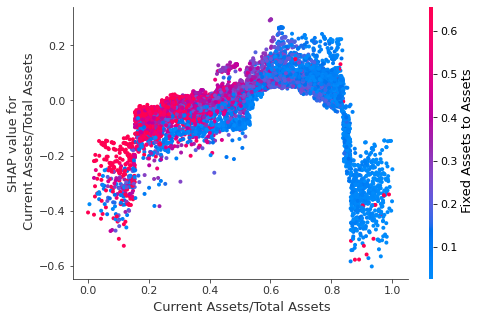

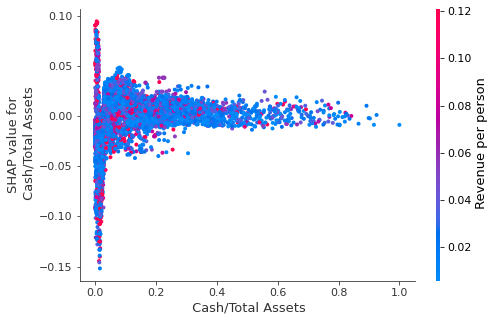

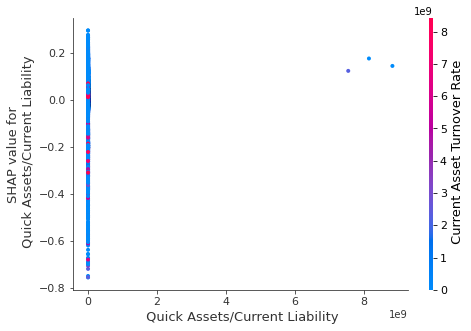

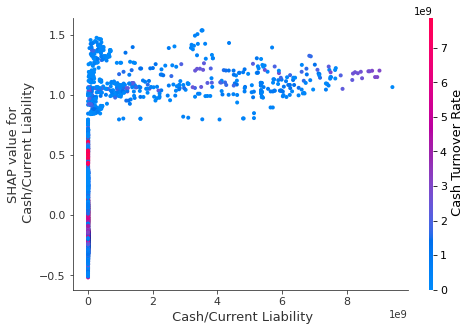

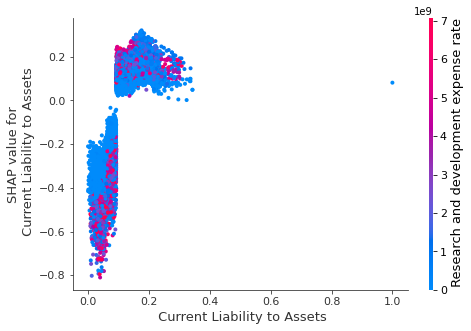

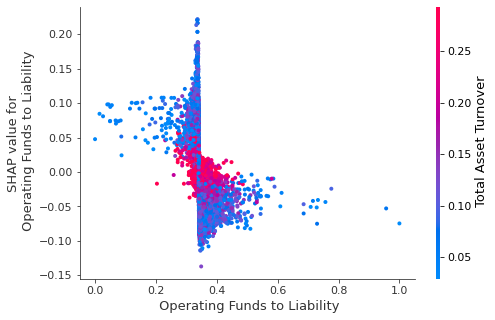

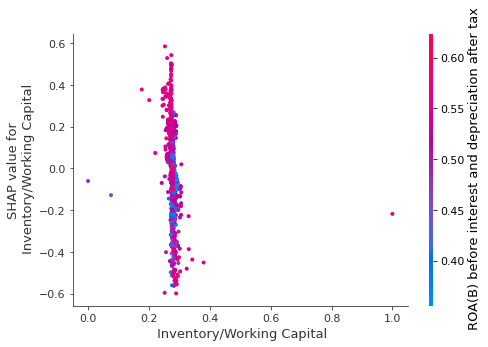

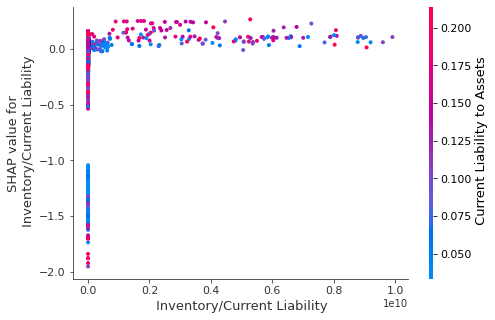

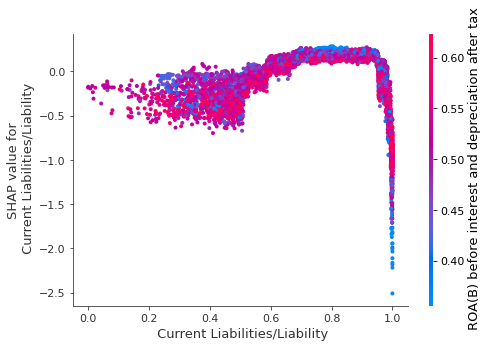

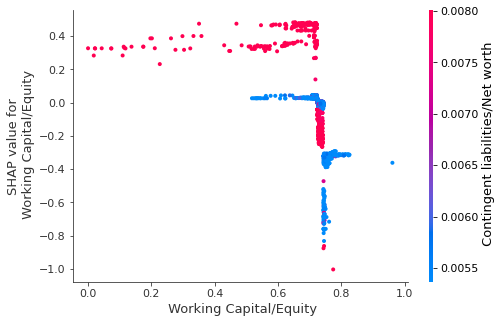

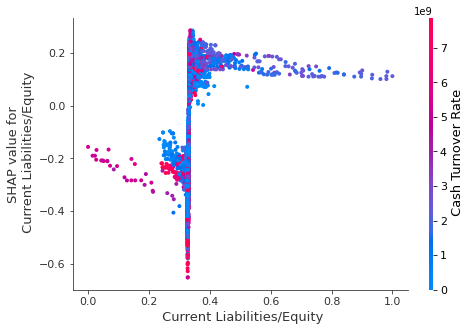

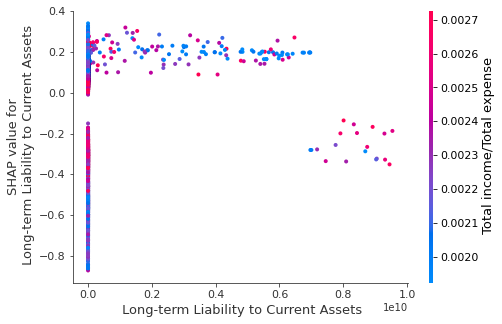

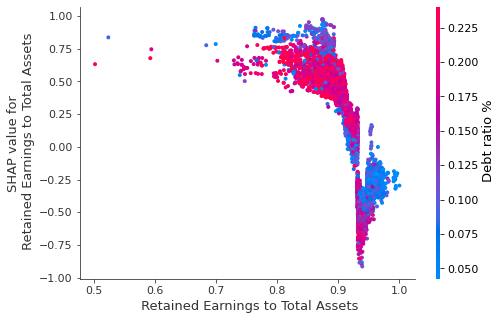

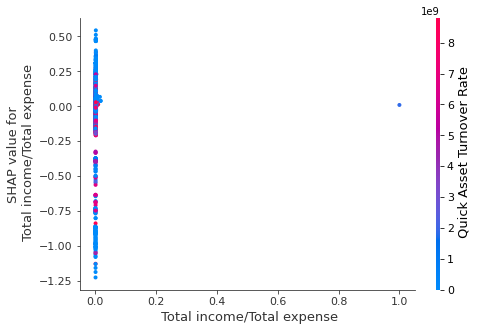

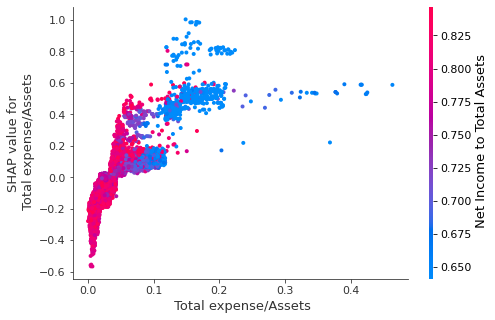

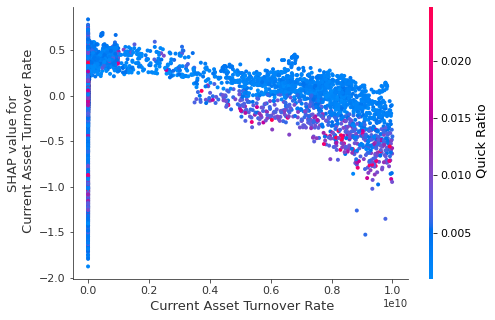

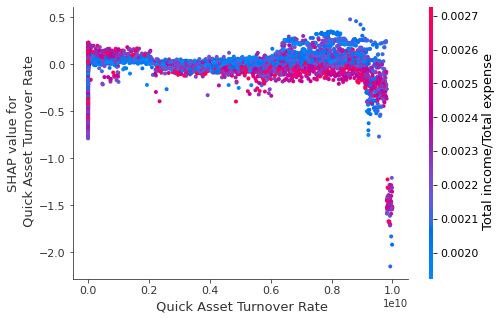

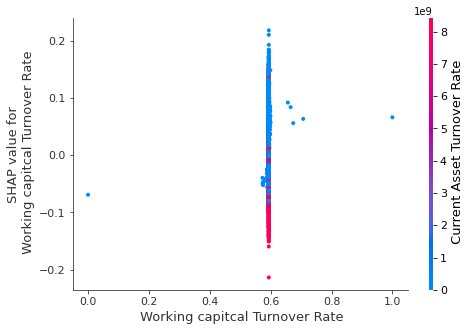

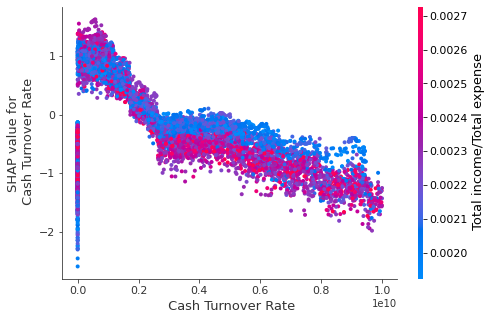

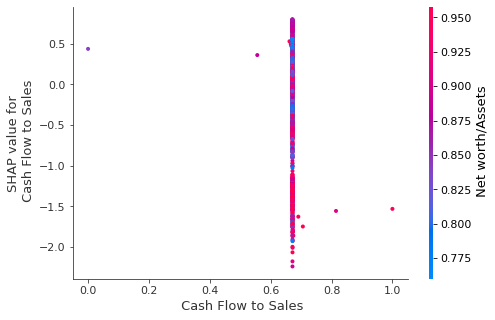

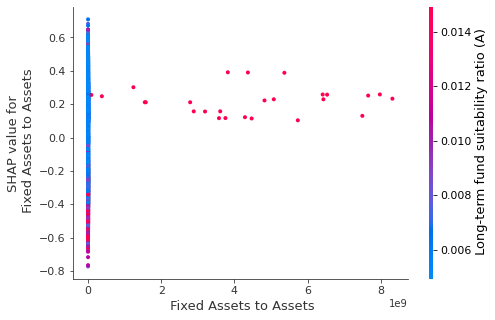

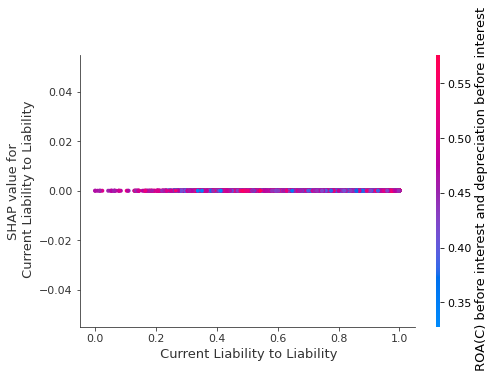

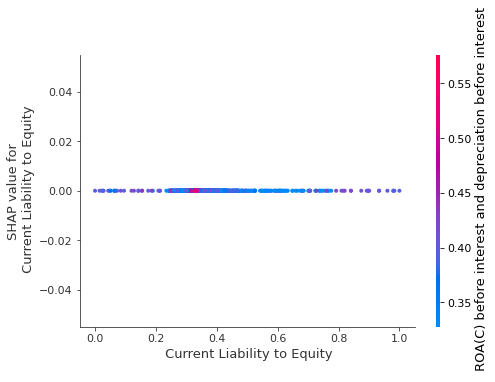

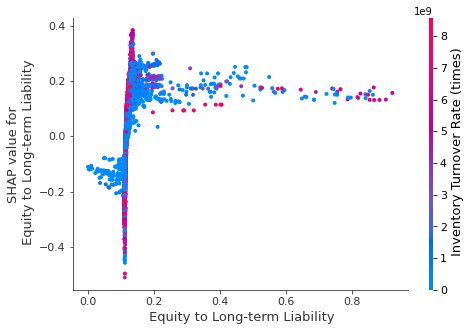

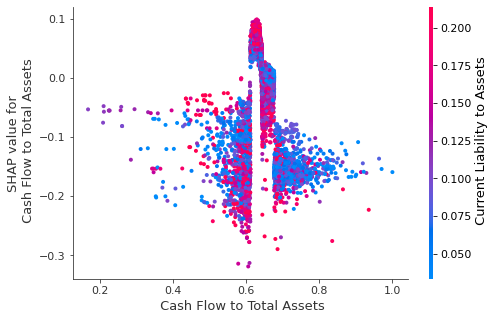

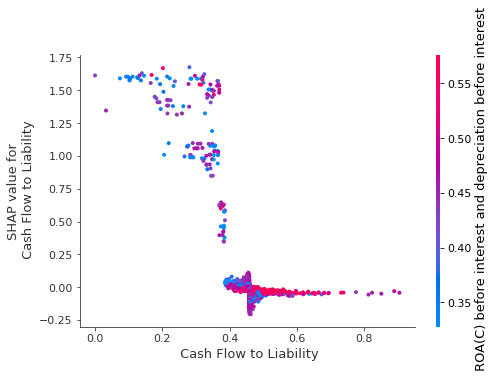

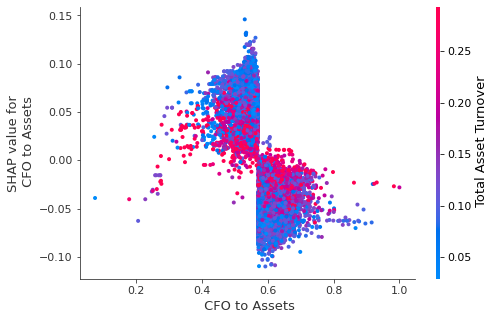

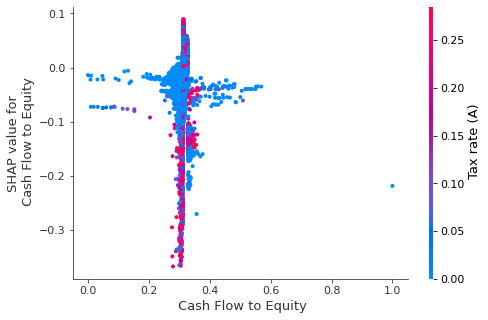

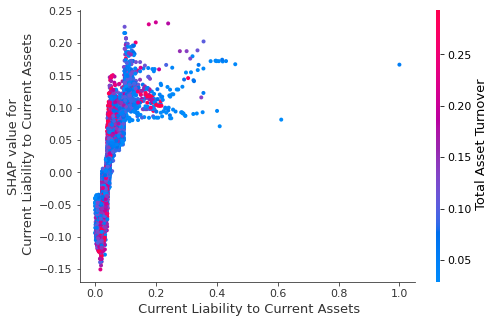

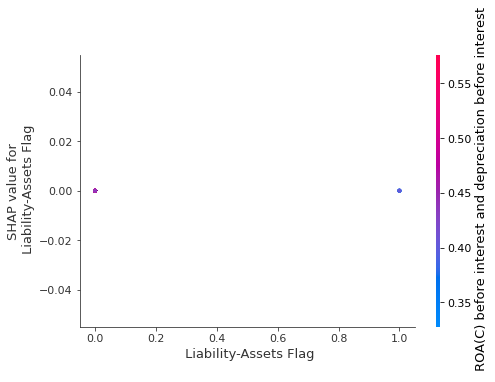

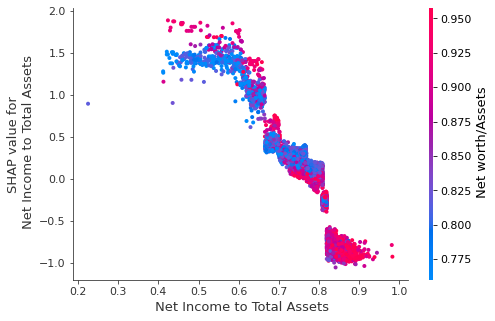

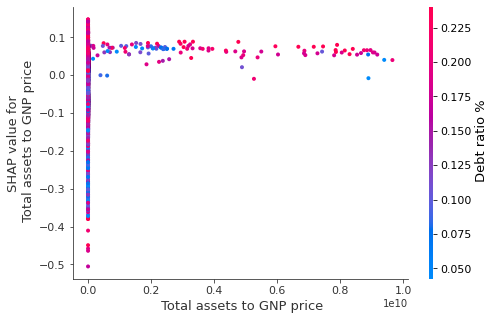

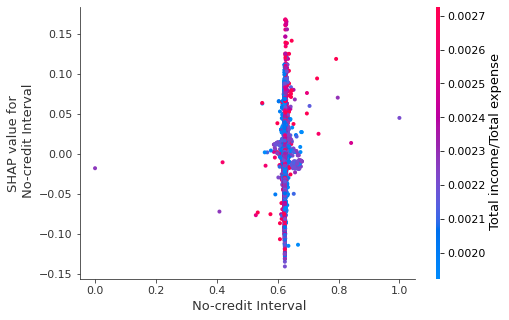

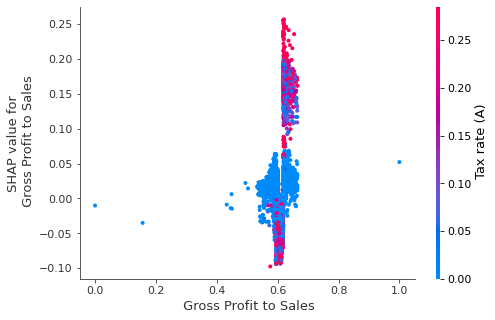

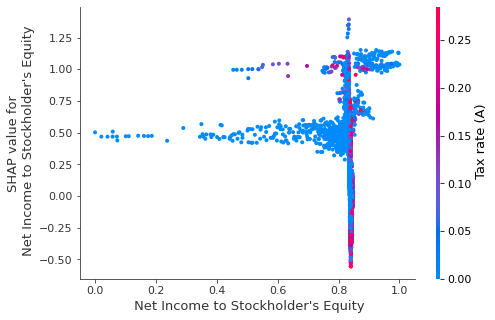

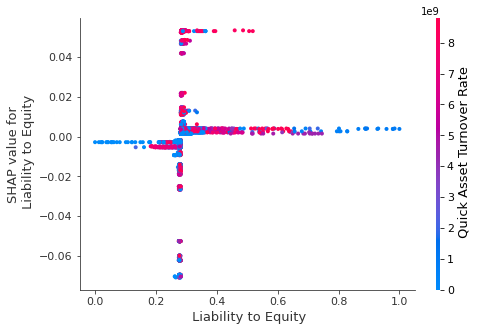

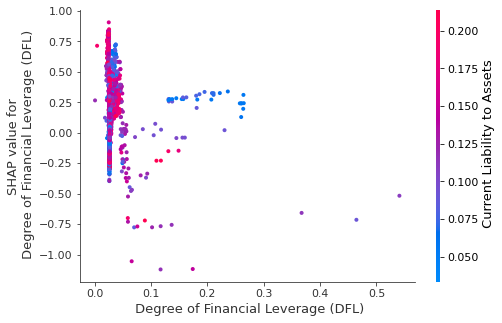

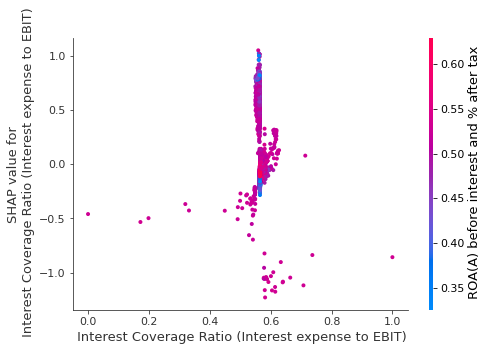

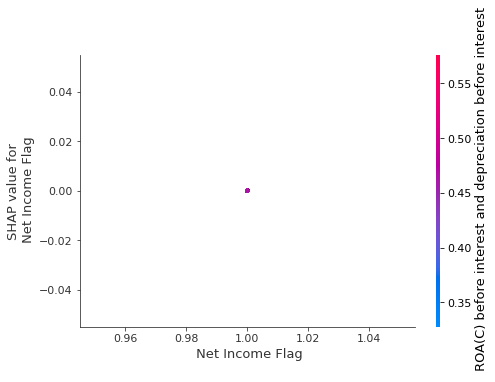

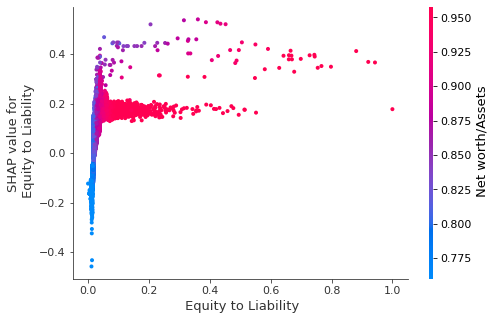

In [63]:
for name in X.columns:
    shap.dependence_plot(name, shap_values[1], X)

In [64]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X.iloc[0,:])

In [65]:
shap.force_plot(explainer.expected_value[1], shap_values[1][1,:], X.iloc[1,:])

In [87]:
y

0        0
1        0
2        0
3        0
4        0
        ..
11677    1
11678    1
11679    1
11680    1
11681    1
Name: Bankrupt?, Length: 11682, dtype: int64

In [61]:
c = X_train.columns
c

Index([' ROA(C) before interest and depreciation before interest',
       ' ROA(A) before interest and % after tax',
       ' ROA(B) before interest and depreciation after tax',
       ' Operating Gross Margin', ' Realized Sales Gross Margin',
       ' Operating Profit Rate', ' Pre-tax net Interest Rate',
       ' After-tax net Interest Rate',
       ' Non-industry income and expenditure/revenue',
       ' Continuous interest rate (after tax)', ' Operating Expense Rate',
       ' Research and development expense rate', ' Cash flow rate',
       ' Interest-bearing debt interest rate', ' Tax rate (A)',
       ' Net Value Per Share (B)', ' Net Value Per Share (A)',
       ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons',
       ' Cash Flow Per Share', ' Revenue Per Share (Yuan ¥)',
       ' Operating Profit Per Share (Yuan ¥)',
       ' Per Share Net profit before tax (Yuan ¥)',
       ' Realized Sales Gross Profit Growth Rate',
       ' Operating Profit Growth Rate'

### Visualization

First, let's take a look at the relationship between the top two variables: 
  - Continuous interest rate
  - Total debt/ Total net worth
  
More visualizations are shown on [Heroku app](https://bankruptcy-visualization.herokuapp.com)

In [58]:
output_notebook()

Loading BokehJS ...

In [59]:
# figure1
p1 = figure(plot_width=500, plot_height=500)

colormap = {0:'green', 1: 'red'}
colors= [colormap[x] for x in df['Bankrupt?']]

p1.circle(df[' Continuous interest rate (after tax)'], 
         df[' Total debt/Total net worth'], 
         size=10, line_color='black', fill_color=colors, fill_alpha=0.2)

p1.xaxis.axis_label='Continuous interest rate (after tax)'
p1.yaxis.axis_label='Total debt/Total net worth'

#figure2
p2 = figure(plot_width=500, plot_height=500)

colormap = {0:'green', 1: 'red'}
colors= [colormap[x] for x in df['Bankrupt?']]

p2.circle(df[' Continuous interest rate (after tax)'], 
         df[' Retained Earnings to Total Assets'], 
         size=10, line_color='black', fill_color=colors, fill_alpha=0.2)

p2.xaxis.axis_label='Continuous interest rate (after tax)'
p2.yaxis.axis_label='Retained Earnings to Total Assets'


show(row(p1, p2))

<a id='conclusion'></a>
## Conclusion

The performance of the LightGBM model is pretty good, with accuracy 0.99 and F1-score 0.99. This model could help investigators distinguish companies with potentiation before making business decisions. 